In [ ]:
from __future__ import print_function, division
import os
import torch
import random
from torchvision.transforms import ToTensor, ToPILImage
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler, Subset
from torchvision import transforms, utils
import torch.nn as nn
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple
from functools import partial
from math import *
from IPython.display import HTML
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
import time
import seaborn as sns
import random

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report, roc_curve, auc, precision_recall_curve

from torch.optim.lr_scheduler import StepLR
from transformers import BatchEncoding

from matplotlib import rc, cm
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df = pd.read_csv('/kaggle/input/fakenewscleaned/dataset/train_data.csv')
val_df = pd.read_csv('/kaggle/input/fakenewscleaned/dataset/val_data.csv')
test_df = pd.read_csv('/kaggle/input/fakenewscleaned/dataset/test_data.csv')

In [ ]:
train_df['content'] = train_df['title'] + ' ' + train_df['text']
val_df['content'] = val_df['title'] + ' ' + val_df['text']
test_df['content'] = test_df['title'] + ' ' + test_df['text']

In [ ]:
model_name = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# torch.serialization.add_safe_globals([BatchEncoding])

if not os.path.exists("/kaggle/input/tinybert-encodings/tinybert_train_encodings.pt"):
    train_encodings = tokenizer(train_df['content'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
    val_encodings = tokenizer(val_df['content'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
    test_encodings = tokenizer(test_df['content'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
else:
    train_encodings = torch.load("/kaggle/input/tinybert-encodings/tinybert_train_encodings.pt")
    val_encodings = torch.load("/kaggle/input/tinybert-encodings/tinybert_val_encodings.pt")
    test_encodings = torch.load("/kaggle/input/tinybert-encodings/tinybert_test_encodings.pt")

In [ ]:
if not os.path.exists("/kaggle/input/tinybert-encodings/tinybert_train_encodings.pt"):
    torch.save(train_encodings, "tinybert_train_encodings.pt")
    torch.save(val_encodings, "tinybert_val_encodings.pt")
    torch.save(test_encodings, "tinybert_test_encodings.pt")

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        #item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # input_ids, attention_mask are the most important
        item = {}
        item['input_ids'] =  torch.tensor(self.encodings["input_ids"][idx])
        item['attention_mask'] = torch.tensor(self.encodings["attention_mask"][idx])
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_df['label'].tolist())
val_dataset = FakeNewsDataset(val_encodings, val_df['label'].tolist())
test_dataset = FakeNewsDataset(test_encodings, test_df['label'].tolist())

random_indices_train = random.sample(range(len(train_dataset)), 4000) # 32000
random_indices_val = random.sample(range(len(val_dataset)), 500) # 4000

train_subset = Subset(train_dataset, random_indices_train)
val_subset = Subset(val_dataset, random_indices_val)
# test_subset = Subset(test_dataset, range(500))

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler=None):
    model.train()
    epoch_loss = 0.0
    num_batches = len(dataloader)
    predictions = []
    labels = []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        predicted_classes = torch.argmax(outputs.logits, dim=1)
        predicted_classes = predicted_classes.cpu().detach().numpy()

        predictions.extend(predicted_classes)
        labels.extend(batch['labels'].cpu().detach().numpy())

        loss = outputs.loss # we use the model's loss
        loss_scalar = loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if scheduler:
            scheduler.step()
        epoch_loss += loss_scalar

    epoch_loss /= num_batches
    return epoch_loss, predictions, labels

def eval_epoch(model, dataloader):
    model.eval()
    epoch_loss = 0.0
    num_batches = len(dataloader)
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)

            predicted_classes = torch.argmax(outputs.logits, dim=1)
            predicted_classes = predicted_classes.cpu().detach().numpy()

            predictions.extend(predicted_classes)
            labels.extend(batch['labels'].cpu().detach().numpy())

            loss = outputs.loss # we use the model's loss
            loss_scalar = loss.item()
            epoch_loss += loss_scalar

    epoch_loss /= num_batches
    return epoch_loss, predictions, labels

In [ ]:
def compute_accuracy(predictions, labels):
    correct = 0.0
    for i in range(len(predictions)):
        if predictions[i] == labels[i]:
            correct += 1

    epoch_accuracy = correct / len(predictions)
    return epoch_accuracy

In [ ]:
hyperparams = {
    'num_epochs': 5,
    'lr': 1e-4,
    'step_size': None,
    'gamma': None,
}
hyperparams_str = "%".join(f"{k}-{v}" for k, v in hyperparams.items())


optimizer = AdamW(model.parameters(), lr=hyperparams['lr'])
#scheduler = StepLR(optimizer, step_size=hyperparams['step_size'], gamma=hyperparams['gamma'])
scheduler = None

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch_idx in tqdm(range(hyperparams['num_epochs'])):
    train_epoch_loss, train_predictions, train_labels = train_epoch(model, train_loader, optimizer, scheduler)
    val_epoch_loss, val_predictions, val_labels = eval_epoch(model, val_loader)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_epoch_accuracy = compute_accuracy(train_predictions, train_labels)
    val_epoch_accuracy = compute_accuracy(val_predictions, val_labels)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    if val_epoch_accuracy > best_val_acc:
        best_val_acc = val_epoch_accuracy
        torch.save(model.state_dict(), f'./best_model_init_{hyperparams_str}.pth')

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx,
        train_epoch_loss,
        train_epoch_accuracy,
        val_epoch_loss,
        val_epoch_accuracy
    ))

 20%|██        | 1/5 [00:40<02:40, 40.05s/it]

epoch 0, train loss=0.593394, train acc=0.634750, val loss=0.321379, val acc=0.862000


 40%|████      | 2/5 [01:22<02:03, 41.33s/it]

epoch 1, train loss=0.209740, train acc=0.929750, val loss=0.183483, val acc=0.926000


 60%|██████    | 3/5 [02:08<01:27, 43.54s/it]

epoch 2, train loss=0.076811, train acc=0.975250, val loss=0.182105, val acc=0.948000


 80%|████████  | 4/5 [02:54<00:44, 44.39s/it]

epoch 3, train loss=0.040118, train acc=0.990500, val loss=0.143258, val acc=0.962000


100%|██████████| 5/5 [03:39<00:00, 43.98s/it]

epoch 4, train loss=0.032224, train acc=0.992500, val loss=0.142254, val acc=0.958000


In [ ]:
def plot_losses(train_losses, val_losses):
    %matplotlib inline
    plt.figure(figsize=(10, 6))
    plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
    plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    %matplotlib inline
    plt.figure(figsize=(10, 6))
    plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
    plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def print_f1_score(predictions, labels):
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", f1_score)

def plot_classification_report(report, title):
    %matplotlib inline
    report_df = pd.DataFrame(report).T
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f', cbar=False)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(predictions, labels, title):
    %matplotlib inline
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground Truth')
    plt.show()

def plot_roc_curve(labels, predictions, title):
    %matplotlib inline
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(labels, predictions, title):
    %matplotlib inline
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

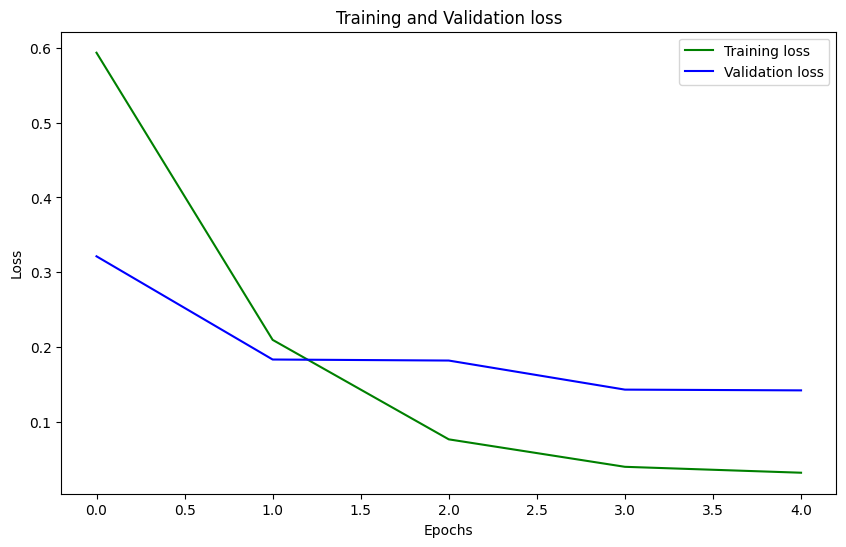

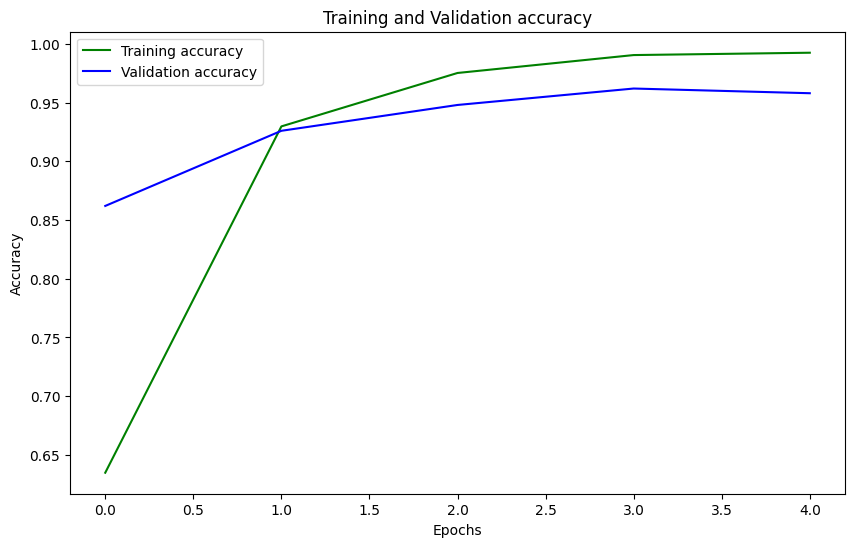

Precision:  0.9595141700404858
Recall:  0.9556451612903226
F1-score:  0.9575757575757576


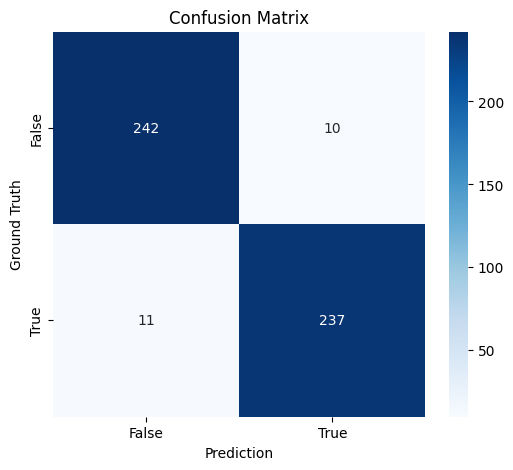

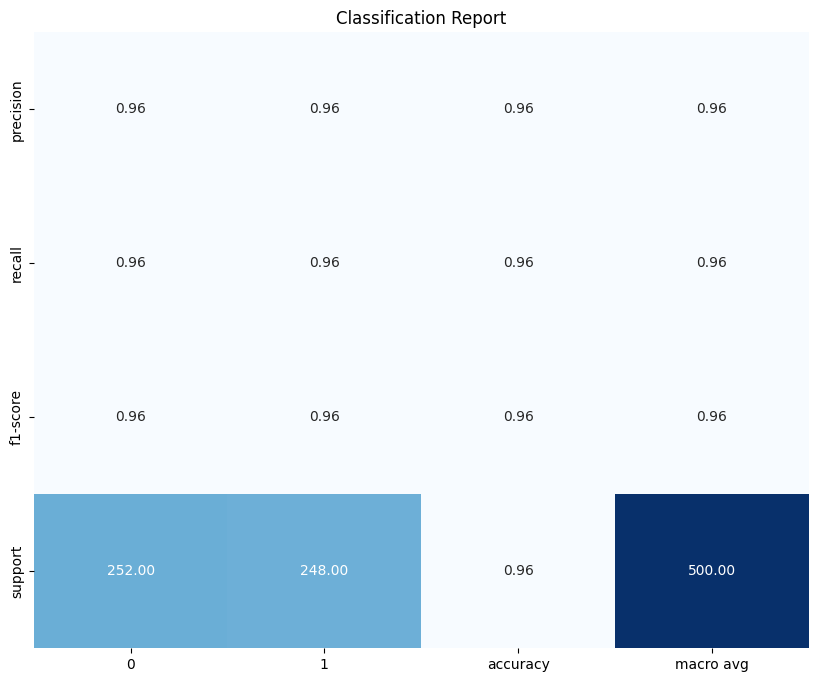

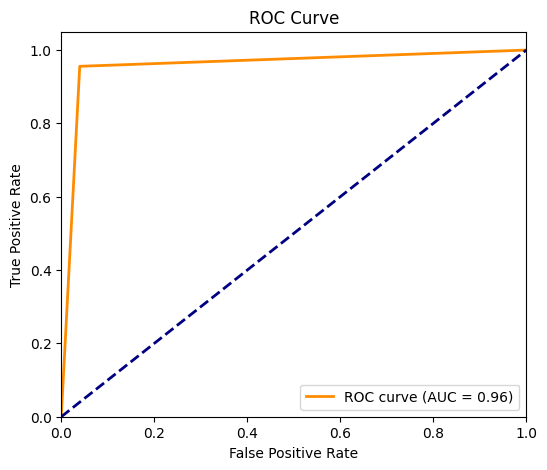

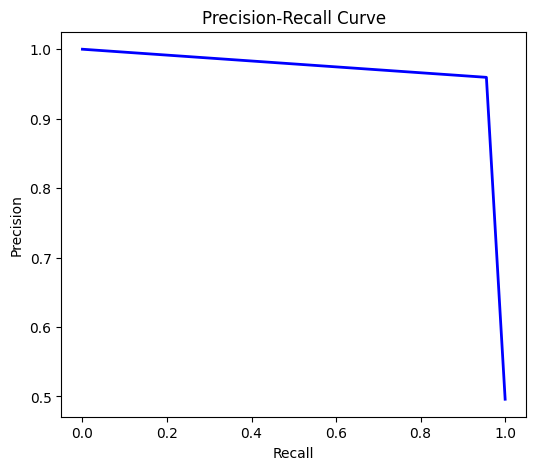

In [ ]:
# plot all the metrics on the validation set after training
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

print_f1_score(val_predictions, val_labels)
plot_confusion_matrix(val_predictions, val_labels, "Confusion Matrix")

classification_report_dict = classification_report(val_labels, val_predictions, output_dict=True)
plot_classification_report(classification_report_dict, "Classification Report")

plot_roc_curve(val_labels, val_predictions, "ROC Curve")
plot_precision_recall_curve(val_labels, val_predictions, "Precision-Recall Curve")

In [ ]:
# test the model
test_loss, test_predictions, test_labels = eval_epoch(model, test_loader)

In [ ]:
print(f"Test Loss: {test_loss:.4f}")

test_accuracy = compute_accuracy(test_predictions, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1627
Test Accuracy: 0.9587


Precision:  0.9661412726211325
Recall:  0.9500574052812859
F1-score:  0.9580318379160637


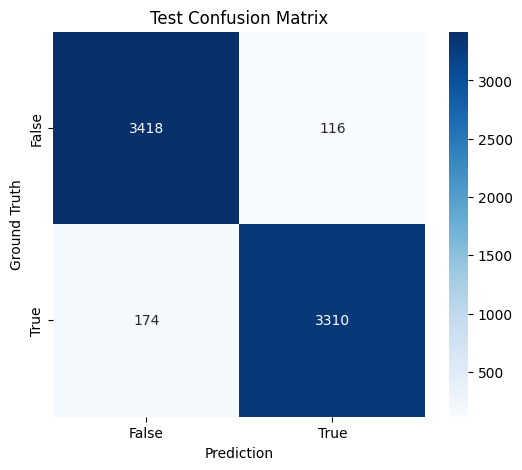

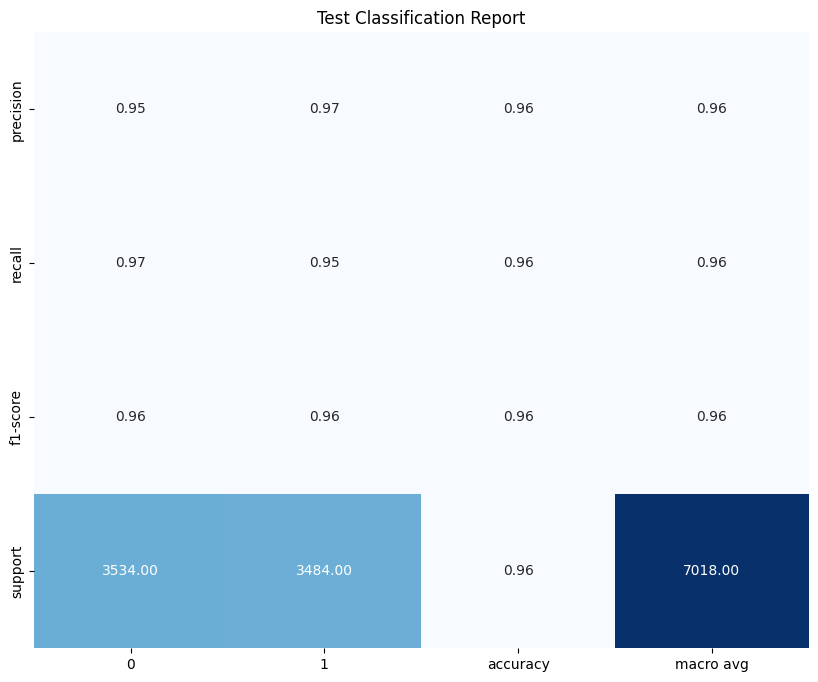

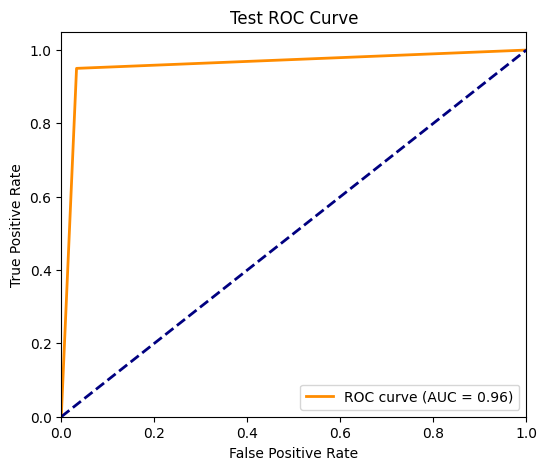

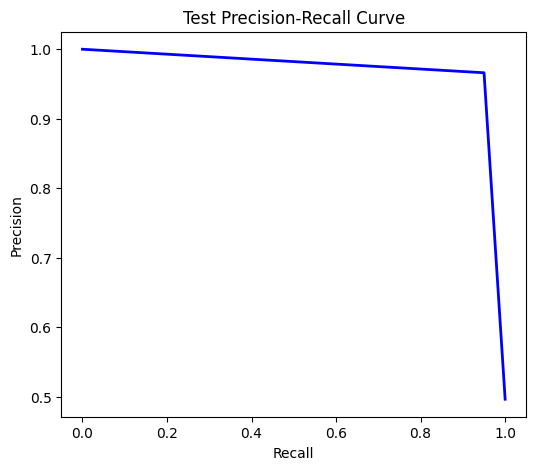

In [ ]:
print_f1_score(test_predictions, test_labels)
plot_confusion_matrix(test_predictions, test_labels, "Test Confusion Matrix")

test_classification_report = classification_report(test_labels, test_predictions, output_dict=True)
plot_classification_report(test_classification_report, "Test Classification Report")

plot_roc_curve(test_labels, test_predictions, "Test ROC Curve")
plot_precision_recall_curve(test_labels, test_predictions, "Test Precision-Recall Curve")

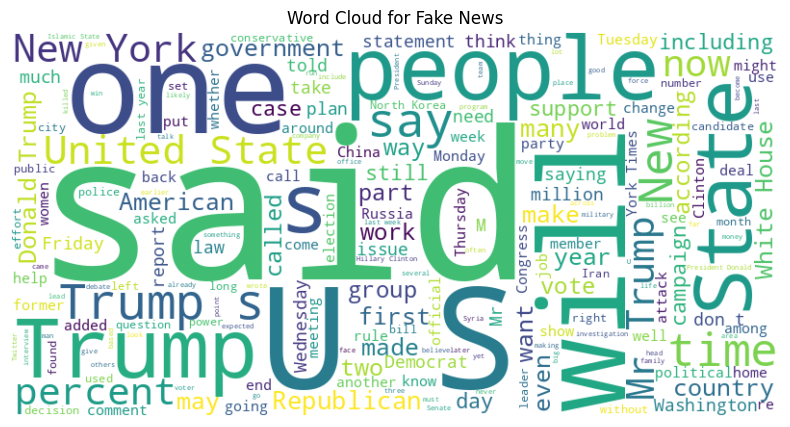

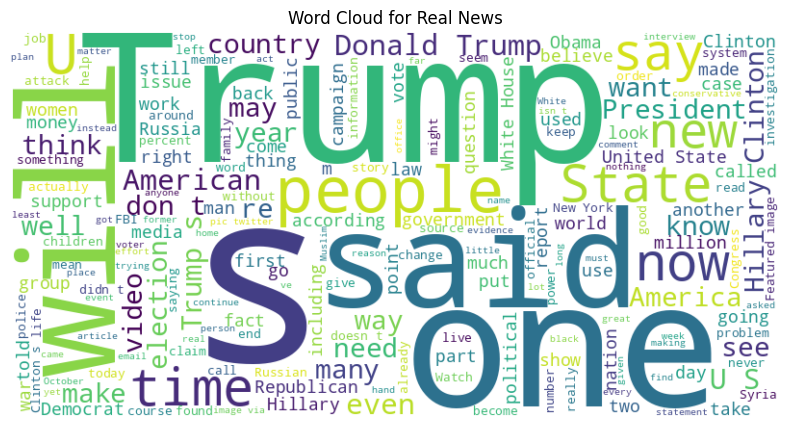

In [ ]:
from wordcloud import WordCloud

# generate word clouds on the test data
def generate_word_cloud(data, label_column, text_column, target_label):
    filtered_text = " ".join(data[data[label_column] == target_label][text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {"Fake" if target_label == 0 else "Real"} News')
    plt.show()

generate_word_cloud(test_df, 'label', 'content', target_label=0)
generate_word_cloud(test_df, 'label', 'content', target_label=1)